# Check the Runtime

In [0]:
from psutil import *
vCPU = str(cpu_count()) + " vCPU"
vCPU

Out[2]: '4 vCPU'

# Download TPCH-SF10 Parquet files

I am hosting the data in my google drive, sometimes the download does not work :(

In [0]:
!curl -L 'https://drive.google.com/uc?export=download&id=18gv0Yd_a-Zc7CSolol8qeYVAAzSthnSN&confirm=t' > lineitem.parquet
!curl -L 'https://drive.google.com/uc?export=download&id=14fyJnKFkCPcQw1q9dG0BE1t7RNNmYP8C&confirm=t' > customer.parquet
!curl -L 'https://drive.google.com/uc?export=download&id=1xRLds4nlBeXk8GTHcJu-Gd3ycN6j6r55&confirm=t' > orders.parquet
!curl -L 'https://drive.google.com/uc?export=download&id=1zFr-XGjGZmVC9l85HUGgn0UdxstmJIGW&confirm=t' > supplier.parquet
!curl -L 'https://drive.google.com/uc?export=download&id=1Dy078NJ2AwyJ5i3ssTQ1JcxbaOtSo5vR&confirm=t' > partsupp.parquet
!curl -L 'https://drive.google.com/uc?export=download&id=1GNRK9WJnPnoust9dE_aIKEFu_aNlAuSo&confirm=t' > region.parquet
!curl -L 'https://drive.google.com/uc?export=download&id=1Hgnv0o1Aie20yRvL9OJ8aTt_9jz1x-L9&confirm=t' > nation.parquet
!curl -L 'https://drive.google.com/uc?export=download&id=1wMPtpQ0rNsXmNJ5Iys_Ezrb9e4wn3f6U&confirm=t' > part.parquet

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1717M  100 1717M    0     0  37.2M      0  0:00:46  0:00:46 --:--:-- 36.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
100 77.2M  100 77.2M    0     0  12.2M      0  0:00:06  0:00:06 --:--:-- 25.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  380M  100  380M    0     0  29.1M      0  0:00:13  0:00:13 --:--:-- 27.7M
  % Total    % Received % Xferd  Average Speed   Tim

# Function to Print results

In [0]:
%%time
import time
import pandas as pd
def execute_query(engine, sql_script):
    df = pd.DataFrame(columns=['dur'])
    sql_arr = sql_script.split(";")
    for sql in sql_arr:
        if len(sql.strip()) > 0:
            start = time.time()
            engine.sql(sql).show()
            stop = time.time()
            duration = stop-start
            print(duration)
            df = df.append({'dur': duration}, ignore_index=True)
    return df       

CPU times: user 849 ms, sys: 138 ms, total: 987 ms
Wall time: 1.28 s


# SQL Query

In [0]:
sql=('''
SELECT
    --Query01
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= CAST('1998-09-02' AS date)
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;
SELECT
    --Query02
    s_acctbal,
    s_name,
    n_name,
    p_partkey,
    p_mfgr,
    s_address,
    s_phone,
    s_comment
FROM
    part,
    supplier,
    partsupp,
    nation,
    region
WHERE
    p_partkey = ps_partkey
    AND s_suppkey = ps_suppkey
    AND p_size = 15
    AND p_type LIKE '%BRASS'
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'EUROPE'
    AND ps_supplycost = (
        SELECT
            MIN(ps_supplycost)
        FROM
            partsupp,
            supplier,
            nation,
            region
        WHERE
            p_partkey = ps_partkey
            AND s_suppkey = ps_suppkey
            AND s_nationkey = n_nationkey
            AND n_regionkey = r_regionkey
            AND r_name = 'EUROPE'
    )
ORDER BY
    s_acctbal DESC,
    n_name,
    s_name,
    p_partkey
LIMIT
    100;







SELECT
    --Query03
    l_orderkey,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    o_orderdate,
    o_shippriority
FROM
    customer,
    orders,
    lineitem
WHERE
    c_mktsegment = 'BUILDING'
    AND c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate < CAST('1995-03-15' AS date)
    AND l_shipdate > CAST('1995-03-15' AS date)
GROUP BY
    l_orderkey,
    o_orderdate,
    o_shippriority
ORDER BY
    revenue DESC,
    o_orderdate
LIMIT
    10;


    





SELECT
    --Query04
    o_orderpriority,
    COUNT(*) AS order_count
FROM
    orders
WHERE
    o_orderdate >= CAST('1993-07-01' AS date)
    AND o_orderdate < CAST('1993-10-01' AS date)
    AND EXISTS (
        SELECT
            *
        FROM
            lineitem
        WHERE
            l_orderkey = o_orderkey
            AND l_commitdate < l_receiptdate
    )
GROUP BY
    o_orderpriority
ORDER BY
    o_orderpriority;


    





SELECT
    --Query05
    n_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    customer,
    orders,
    lineitem,
    supplier,
    nation,
    region
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND l_suppkey = s_suppkey
    AND c_nationkey = s_nationkey
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'ASIA'
    AND o_orderdate >= CAST('1994-01-01' AS date)
    AND o_orderdate < CAST('1995-01-01' AS date)
GROUP BY
    n_name
ORDER BY
    revenue DESC;


    




SELECT
    --Query06
    SUM(l_extendedprice * l_discount) AS revenue
FROM
    lineitem
WHERE
    l_shipdate >= CAST('1994-01-01' AS date)
    AND l_shipdate < CAST('1995-01-01' AS date)
    AND l_discount BETWEEN 0.05
    AND 0.07
    AND l_quantity < 24;


    




SELECT
    --Query07
    supp_nation,
    cust_nation,
    l_year,
    SUM(volume) AS revenue
FROM
    (
        SELECT
            n1.n_name AS supp_nation,
            n2.n_name AS cust_nation,
            EXTRACT(
                year
                FROM
                    l_shipdate
            ) AS l_year,
            l_extendedprice * (1 - l_discount) AS volume
        FROM
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2
        WHERE
            s_suppkey = l_suppkey
            AND o_orderkey = l_orderkey
            AND c_custkey = o_custkey
            AND s_nationkey = n1.n_nationkey
            AND c_nationkey = n2.n_nationkey
            AND (
                (
                    n1.n_name = 'FRANCE'
                    AND n2.n_name = 'GERMANY'
                )
                OR (
                    n1.n_name = 'GERMANY'
                    AND n2.n_name = 'FRANCE'
                )
            )
            AND l_shipdate BETWEEN CAST('1995-01-01' AS date)
            AND CAST('1996-12-31' AS date)
    ) AS shipping
GROUP BY
    supp_nation,
    cust_nation,
    l_year
ORDER BY
    supp_nation,
    cust_nation,
    l_year;


    




SELECT
    --Query08
    o_year,
    SUM(
        CASE
            WHEN nation = 'BRAZIL' THEN volume
            ELSE 0
        END
    ) / SUM(volume) AS mkt_share
FROM
    (
        SELECT
            EXTRACT(
                year
                FROM
                    o_orderdate
            ) AS o_year,
            l_extendedprice * (1 - l_discount) AS volume,
            n2.n_name AS nation
        FROM
            part,
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2,
            region
        WHERE
            p_partkey = l_partkey
            AND s_suppkey = l_suppkey
            AND l_orderkey = o_orderkey
            AND o_custkey = c_custkey
            AND c_nationkey = n1.n_nationkey
            AND n1.n_regionkey = r_regionkey
            AND r_name = 'AMERICA'
            AND s_nationkey = n2.n_nationkey
            AND o_orderdate BETWEEN CAST('1995-01-01' AS date)
            AND CAST('1996-12-31' AS date)
            AND p_type = 'ECONOMY ANODIZED STEEL'
    ) AS all_nations
GROUP BY
    o_year
ORDER BY
    o_year;


    







SELECT
    --Query09
    nation,
    o_year,
    SUM(amount) AS sum_profit
FROM
    (
        SELECT
            n_name AS nation,
            EXTRACT(
                year
                FROM
                    o_orderdate
            ) AS o_year,
            l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity AS amount
        FROM
            part,
            supplier,
            lineitem,
            partsupp,
            orders,
            nation
        WHERE
            s_suppkey = l_suppkey
            AND ps_suppkey = l_suppkey
            AND ps_partkey = l_partkey
            AND p_partkey = l_partkey
            AND o_orderkey = l_orderkey
            AND s_nationkey = n_nationkey
            AND p_name LIKE '%green%'
    ) AS profit
GROUP BY
    nation,
    o_year
ORDER BY
    nation,
    o_year DESC;


    





SELECT
    --Query10
    c_custkey,
    c_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    c_acctbal,
    n_name,
    c_address,
    c_phone,
    c_comment
FROM
    customer,
    orders,
    lineitem,
    nation
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate >= CAST('1993-10-01' AS date)
    AND o_orderdate < CAST('1994-01-01' AS date)
    AND l_returnflag = 'R'
    AND c_nationkey = n_nationkey
GROUP BY
    c_custkey,
    c_name,
    c_acctbal,
    c_phone,
    n_name,
    c_address,
    c_comment
ORDER BY
    revenue DESC
LIMIT
    20;







SELECT
    --Query11
    ps_partkey,
    SUM(ps_supplycost * ps_availqty) AS value
FROM
    partsupp,
    supplier,
    nation
WHERE
    ps_suppkey = s_suppkey
    AND s_nationkey = n_nationkey
    AND n_name = 'GERMANY'
GROUP BY
    ps_partkey
HAVING
    SUM(ps_supplycost * ps_availqty) > (
        SELECT
            SUM(ps_supplycost * ps_availqty) * (0.0001/10)
            -- SUM(ps_supplycost * ps_availqty) * 1
        FROM
            partsupp,
            supplier,
            nation
        WHERE
            ps_suppkey = s_suppkey
            AND s_nationkey = n_nationkey
            AND n_name = 'GERMANY'
    )
ORDER BY
    value DESC;


    





SELECT
    --Query12
    l_shipmode,
    SUM(
        CASE
            WHEN o_orderpriority = '1-URGENT'
            OR o_orderpriority = '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS high_line_count,
    SUM(
        CASE
            WHEN o_orderpriority <> '1-URGENT'
            AND o_orderpriority <> '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS low_line_count
FROM
    orders,
    lineitem
WHERE
    o_orderkey = l_orderkey
    AND l_shipmode IN ('MAIL', 'SHIP')
    AND l_commitdate < l_receiptdate
    AND l_shipdate < l_commitdate
    AND l_receiptdate >= CAST('1994-01-01' AS date)
    AND l_receiptdate < CAST('1995-01-01' AS date)
GROUP BY
    l_shipmode
ORDER BY
    l_shipmode;


    





SELECT
    --Query13
    c_count,
    COUNT(*) AS custdist
FROM
    (
        SELECT
            c_custkey,
            COUNT(o_orderkey) AS c_count
        FROM
            customer
            LEFT OUTER JOIN orders ON c_custkey = o_custkey
            AND o_comment NOT LIKE '%special%requests%'
        GROUP BY
            c_custkey
    ) AS c_orders
GROUP BY
    c_count
ORDER BY
    custdist DESC,
    c_count DESC;


    





SELECT
    --Query14
    100.00 * SUM(
        CASE
            WHEN p_type LIKE 'PROMO%' THEN l_extendedprice * (1 - l_discount)
            ELSE 0
        END
    ) / SUM(l_extendedprice * (1 - l_discount)) AS promo_revenue
FROM
    lineitem,
    part
WHERE
    l_partkey = p_partkey
    AND l_shipdate >= date '1995-09-01'
    AND l_shipdate < CAST('1995-10-01' AS date);


    





SELECT
    --Query15
    s_suppkey,
    s_name,
    s_address,
    s_phone,
    total_revenue
FROM
    supplier,
    (
        SELECT
            l_suppkey AS supplier_no,
            SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
        FROM
            lineitem
        WHERE
            l_shipdate >= CAST('1996-01-01' AS date)
            AND l_shipdate < CAST('1996-04-01' AS date)
        GROUP BY
            supplier_no
    ) revenue0
WHERE
    s_suppkey = supplier_no
    AND total_revenue = (
        SELECT
            MAX(total_revenue)
        FROM
            (
                SELECT
                    l_suppkey AS supplier_no,
                    SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
                FROM
                    lineitem
                WHERE
                    l_shipdate >= CAST('1996-01-01' AS date)
                    AND l_shipdate < CAST('1996-04-01' AS date)
                GROUP BY
                    supplier_no
            ) revenue1
    )
ORDER BY
    s_suppkey;


    





SELECT
    --Query16
    p_brand,
    p_type,
    p_size,
    COUNT(DISTINCT ps_suppkey) AS supplier_cnt
FROM
    partsupp,
    part
WHERE
    p_partkey = ps_partkey
    AND p_brand <> 'Brand#45'
    AND p_type NOT LIKE 'MEDIUM POLISHED%'
    AND p_size IN (
        49,
        14,
        23,
        45,
        19,
        3,
        36,
        9
    )
    AND ps_suppkey NOT IN (
        SELECT
            s_suppkey
        FROM
            supplier
        WHERE
            s_comment LIKE '%Customer%Complaints%'
    )
GROUP BY
    p_brand,
    p_type,
    p_size
ORDER BY
    supplier_cnt DESC,
    p_brand,
    p_type,
    p_size;


    





SELECT
    --Query17
    SUM(l_extendedprice) / 7.0 AS avg_yearly
FROM
    lineitem,
    part
WHERE
    p_partkey = l_partkey
    AND p_brand = 'Brand#23'
    AND p_container = 'MED BOX'
    AND l_quantity < (
        SELECT
            0.2 * AVG(l_quantity)
        FROM
            lineitem
        WHERE
            l_partkey = p_partkey
    );
    





SELECT
    --Query18
    c_name,
    c_custkey,
    o_orderkey,
    o_orderdate,
    o_totalprice,
    SUM(l_quantity)
FROM
    customer,
    orders,
    lineitem
WHERE
    o_orderkey IN (
        SELECT
            l_orderkey
        FROM
            lineitem
        GROUP BY
            l_orderkey
        HAVING
            SUM(l_quantity) > 300
    )
    AND c_custkey = o_custkey
    AND o_orderkey = l_orderkey
GROUP BY
    c_name,
    c_custkey,
    o_orderkey,
    o_orderdate,
    o_totalprice
ORDER BY
    o_totalprice DESC,
    o_orderdate
LIMIT
    100;
    




SELECT
    --Query19
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    lineitem,
    part
WHERE
    (
        p_partkey = l_partkey
        AND p_brand = 'Brand#12'
        AND p_container IN (
            'SM CASE',
            'SM BOX',
            'SM PACK',
            'SM PKG'
        )
        AND l_quantity >= 1
        AND l_quantity <= 1 + 10
        AND p_size BETWEEN 1
        AND 5
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    )
    OR (
        p_partkey = l_partkey
        AND p_brand = 'Brand#23'
        AND p_container IN (
            'MED BAG',
            'MED BOX',
            'MED PKG',
            'MED PACK'
        )
        AND l_quantity >= 10
        AND l_quantity <= 10 + 10
        AND p_size BETWEEN 1
        AND 10
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    )
    OR (
        p_partkey = l_partkey
        AND p_brand = 'Brand#34'
        AND p_container IN (
            'LG CASE',
            'LG BOX',
            'LG PACK',
            'LG PKG'
        )
        AND l_quantity >= 20
        AND l_quantity <= 20 + 10
        AND p_size BETWEEN 1
        AND 15
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    );
    





SELECT
    --Query20
    s_name,
    s_address
FROM
    supplier,
    nation
WHERE
    s_suppkey IN (
        SELECT
            ps_suppkey
        FROM
            partsupp
        WHERE
            ps_partkey IN (
                SELECT
                    p_partkey
                FROM
                    part
                WHERE
                    p_name LIKE 'forest%'
            )
            AND ps_availqty > (
                SELECT
                    0.5 * SUM(l_quantity)
                FROM
                    lineitem
                WHERE
                    l_partkey = ps_partkey
                    AND l_suppkey = ps_suppkey
                    AND l_shipdate >= CAST('1994-01-01' AS date)
                    AND l_shipdate < CAST('1995-01-01' AS date)
            )
    )
    AND s_nationkey = n_nationkey
    AND n_name = 'CANADA'
ORDER BY
    s_name;
    





SELECT
    --Query21
    s_name,
    COUNT(*) AS numwait
FROM
    supplier,
    lineitem l1,
    orders,
    nation
WHERE
    s_suppkey = l1.l_suppkey
    AND o_orderkey = l1.l_orderkey
    AND o_orderstatus = 'F'
    AND l1.l_receiptdate > l1.l_commitdate
    AND EXISTS (
        SELECT
            *
        FROM
            lineitem l2
        WHERE
            l2.l_orderkey = l1.l_orderkey
            AND l2.l_suppkey <> l1.l_suppkey
    )
    AND NOT EXISTS (
        SELECT
            *
        FROM
            lineitem l3
        WHERE
            l3.l_orderkey = l1.l_orderkey
            AND l3.l_suppkey <> l1.l_suppkey
            AND l3.l_receiptdate > l3.l_commitdate
    )
    AND s_nationkey = n_nationkey
    AND n_name = 'SAUDI ARABIA'
GROUP BY
    s_name
ORDER BY
    numwait DESC,
    s_name
LIMIT
    100;
    





SELECT
    --Query22
    cntrycode,
    COUNT(*) AS numcust,
    SUM(c_acctbal) AS totacctbal
FROM
    (
        SELECT
            SUBSTRING(c_phone, 1, 2) AS cntrycode,
            c_acctbal
        FROM
            customer
        WHERE
            SUBSTRING(c_phone, 1, 2) IN (
                '13',
                '31',
                '23',
                '29',
                '30',
                '18',
                '17'
            )
            AND c_acctbal > (
                SELECT
                    AVG(c_acctbal)
                FROM
                    customer
                WHERE
                    c_acctbal > 0.00
                    AND SUBSTRING(c_phone, 1, 2) IN (
                        '13',
                        '31',
                        '23',
                        '29',
                        '30',
                        '18',
                        '17'
                    )
            )
            AND NOT EXISTS (
                SELECT
                    *
                FROM
                    orders
                WHERE
                    o_custkey = c_custkey
            )
    ) AS custsale
GROUP BY
    cntrycode
ORDER BY
    cntrycode;
    
''')

# DuckDB

In [0]:
!pip install duckdb --pre --upgrade

     |███████▌                        | 3.5 M

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 15.1 MB 28.7 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-54cd40ca-0c42-4f86-9e57-9ef254f5cb9c/bin/python -m pip install --upgrade pip' command.


In [0]:
import duckdb 
con = duckdb.connect()
con.execute('''
PRAGMA disable_progress_bar;
PRAGMA enable_object_cache;
CREATE OR REPLACE view lineitem AS SELECT * FROM 'lineitem.parquet';
CREATE OR REPLACE view orders AS SELECT * FROM 'orders.parquet';
CREATE OR REPLACE view partsupp AS SELECT * FROM 'partsupp.parquet';
CREATE OR REPLACE view part AS SELECT * FROM 'part.parquet';
CREATE OR REPLACE view supplier AS SELECT * FROM 'supplier.parquet';
CREATE OR REPLACE view nation AS SELECT * FROM 'nation.parquet';
CREATE OR REPLACE view region AS SELECT * FROM 'region.parquet';
CREATE OR REPLACE view customer AS SELECT * FROM 'customer.parquet';
''')

Out[6]: <duckdb.DuckDBPyConnection at 0x7f2d113e0030>

In [0]:
%%time
duck=execute_query(con, sql)

┌──────────────┬──────────────┬─────────────┬───┬────────────────────┬─────────────────────┬─────────────┐
│ L_RETURNFLAG │ L_LINESTATUS │   sum_qty   │ … │     avg_price      │      avg_disc       │ count_order │
│   varchar    │   varchar    │   double    │   │       double       │       double        │    int64    │
├──────────────┼──────────────┼─────────────┼───┼────────────────────┼─────────────────────┼─────────────┤
│ A            │ F            │ 377518399.0 │ … │ 38237.151008959954 │ 0.05000657453995674 │    14804077 │
│ N            │ F            │   9851614.0 │ … │ 38257.810660080984 │ 0.04997336773768553 │      385998 │
│ N            │ O            │ 743124873.0 │ … │  38233.90292348244 │  0.0500008118219497 │    29144351 │
│ R            │ F            │ 377732830.0 │ … │  38251.21927356008 │ 0.04999679231380126 │    14808183 │
├──────────────┴──────────────┴─────────────┴───┴────────────────────┴─────────────────────┴─────────────┤
│ 4 rows                             

# DuckDB Native Storage

In [0]:
%%time
import duckdb
con = duckdb.connect("TPCH.DUCKDB")
con.execute('''
PRAGMA disable_progress_bar;
CREATE TABLE lineitem AS SELECT * FROM 'lineitem.parquet';
CREATE TABLE orders AS SELECT * FROM 'orders.parquet';
CREATE TABLE partsupp AS SELECT * FROM 'partsupp.parquet';
CREATE TABLE part AS SELECT * FROM 'part.parquet';
CREATE TABLE supplier AS SELECT * FROM 'supplier.parquet';
CREATE TABLE nation AS SELECT * FROM 'nation.parquet';
CREATE TABLE region AS SELECT * FROM 'region.parquet';
CREATE TABLE customer AS SELECT * FROM 'customer.parquet';
''')
con.close()

CPU times: user 3min 31s, sys: 16.3 s, total: 3min 47s
Wall time: 1min 15s


In [0]:
%%time
con = duckdb.connect("TPCH.DUCKDB",read_only=True)
con.execute('''
PRAGMA disable_progress_bar;
PRAGMA enable_object_cache
''')
duck_import=execute_query(con, sql)
con.close()

┌──────────────┬──────────────┬─────────────┬───┬───────────────────┬──────────────────────┬─────────────┐
│ L_RETURNFLAG │ L_LINESTATUS │   sum_qty   │ … │     avg_price     │       avg_disc       │ count_order │
│   varchar    │   varchar    │   double    │   │      double       │        double        │    int64    │
├──────────────┼──────────────┼─────────────┼───┼───────────────────┼──────────────────────┼─────────────┤
│ A            │ F            │ 377518399.0 │ … │ 38237.15100896001 │  0.05000657453995661 │    14804077 │
│ N            │ F            │   9851614.0 │ … │   38257.810660081 │  0.04997336773768556 │      385998 │
│ N            │ O            │ 743124873.0 │ … │ 38233.90292348236 │ 0.050000811821949646 │    29144351 │
│ R            │ F            │ 377732830.0 │ … │ 38251.21927356029 │ 0.049996792313800956 │    14808183 │
├──────────────┴──────────────┴─────────────┴───┴───────────────────┴──────────────────────┴─────────────┤
│ 4 rows                             

# PySpark

In [0]:
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
import pyspark.pandas as ps
import pyspark as spark
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("PySpark Read Parquet").getOrCreate()
lineitem_df = spark.read.parquet('file:/databricks/driver/lineitem.parquet')
lineitem_df.createOrReplaceTempView("lineitem")
orders_df = spark.read.parquet('file:/databricks/driver/orders.parquet')
orders_df.createOrReplaceTempView("orders")
nation_df = spark.read.parquet('file:/databricks/driver/nation.parquet')
nation_df.createOrReplaceTempView("nation")
customer_df = spark.read.parquet('file:/databricks/driver/customer.parquet')
customer_df.createOrReplaceTempView("customer")
partsupp_df = spark.read.parquet('file:/databricks/driver/partsupp.parquet')
partsupp_df.createOrReplaceTempView("partsupp")
supplier_df = spark.read.parquet('file:/databricks/driver/supplier.parquet')
supplier_df.createOrReplaceTempView("supplier")
region_df = spark.read.parquet('file:/databricks/driver/region.parquet')
region_df.createOrReplaceTempView("region")
part_df = spark.read.parquet('file:/databricks/driver/part.parquet')
part_df.createOrReplaceTempView("part")

In [0]:
%%time
apachespark=execute_query(spark, sql)

+------------+------------+------------+--------------------+--------------------+--------------------+------------------+-----------------+--------------------+-----------+
|l_returnflag|l_linestatus|     sum_qty|      sum_base_price|      sum_disc_price|          sum_charge|           avg_qty|        avg_price|            avg_disc|count_order|
+------------+------------+------------+--------------------+--------------------+--------------------+------------------+-----------------+--------------------+-----------+
|           A|           F|3.77518399E8|5.660657277972488E11|5.377591042780679E11|5.592766708921111E11|25.500975103007097|38237.15100895846| 0.05000657454018172|   14804077|
|           N|           F|   9851614.0|1.476743839917003E10|1.402880579221142...|1.459049099836673...|25.522448302840946|38257.81066008122|0.049973367737644825|     385998|
|           N|           O|7.43124873E8|1.114302286901887...|1.058580922144976...|1.100937000170593...|25.498075870689316|38233.90

# Result

In [0]:
import numpy as np
duck['query'] = duck.index
duck_import['query'] = duck_import.index
apachespark['query'] = apachespark.index
con1=duckdb.connect()
concat = con1.sql('''select  duck.dur as duck,duck_import.dur as duck_import ,apachespark.dur as apachespark from duck
left join duck_import
on duck.query=duck_import.query
left join  apachespark 
on duck.query=apachespark.query
''').df()
concat.index = np.arange(1, len(concat)+1)
concat

,duck,duck_import,apachespark
1,5.655131,3.365880,20.120371
2,0.759332,0.330028,6.311003
3,3.502506,1.178892,13.295852
4,2.723280,1.515466,19.830589
5,3.034831,1.169955,27.902017
6,2.962301,0.638939,4.994563
7,6.767324,2.571518,20.862524
8,3.937717,1.347901,11.861343
9,8.620795,4.805861,24.882043
10,4.018725,1.902158,16.091558


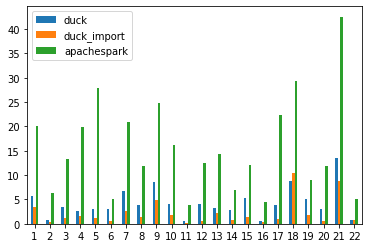

In [0]:
ax = concat.plot.bar(rot=0)

In [0]:
summary= con1.sql(' select sum(duck)/60 as duck, sum(duck_import)/60 as duck_import, sum(apachespark)/60 as apachespark from concat').df()
summary

,duck,duck_import,apachespark
0,1.56075,0.788577,5.673911


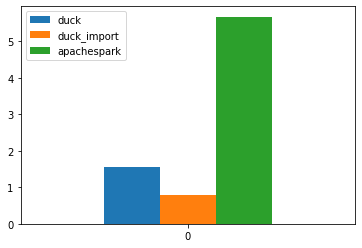

In [0]:
ax = summary.plot.bar(rot=0)